# Introduction

This is a map-reduce version of expectation maximization algo for a mixture of Gaussians model. There are two mrJob MR packages, mr_GMixEmIterate and mr_GMixEmInitialize.  The driver calls the mrJob packages and manages the iteration. 

##<b>E Step </b>: Given priors, mean vector and covariance matrix, calculate the probability of that each data point belongs to a class 

$\omega_k^i = p(w_k | x^i,\theta) =  \frac{\pi_k  \mathcal{N} (x^i | \mu_k,\sum_k)}{\sum_{j=1}^K \mathcal{N}(x^i | \mu_k,\sum_k)} \Rightarrow  $ equation <b>1</b>



where 

* k = number of classes 
* i = example index
* theta = (phi, mu, sigma)
* phi = prior class probability
* mu = centroid 
* Sigma = covariance matrix
* n = number of samples
* pi = prior class probability


$\mathcal{N}(x^i | \mu_k,\sum_k) $ is calculated as below 



$p(x; \mu, \sum) = \frac{1}{(2\pi)^{n/2}\left | \sum \right |^{1/2}} exp  (-\frac{1}{2} (x-\mu)^{T} \sum^{-1} (x-\mu)  ) \Rightarrow $ equation <b>2</b>  



Where $ \left | \sum \right |$ is the determinant of corvariance matrix

<br></br>

##<b>M Step</b>: Given probabilities, update priors, mean and covariance

$Centroid_k \Rightarrow  \hat{\mu_k} =  \frac {1}{n_k} \sum_{i=1}^n p(w_k | x_i, \theta)x^i $

which is calculated as  

$ Centroid_k \Rightarrow  \mu_k = \frac{ \sum_{i=1}^{n} \omega_k^i x^i }{\sum_{i=1}^{m} \omega_k^i } \Rightarrow$ equation <b>3</b>

<br></br>

$Covariance_k \Rightarrow \hat{\sum_k} =  \frac {1}{n_k} \sum_{i=1}^n p(w_k | x_i, \theta) (x^i -\hat{\mu_k}) (x^i -\hat{\mu_k})^T $

which is calculated as 

$Covariance_k \Rightarrow \sum_k = \frac{ \sum_{i=1}^{n} \omega_k^i (x^i-\mu_k)(x^i-\mu)^T} {\sum_{i=1}^{m} \omega_k^i}\Rightarrow$ equation <b>4</b>

<br></br>

$Prior_k \Rightarrow \hat{\pi_k} =  \frac {n_k}{n} $where $ n_k =  \sum_{i=1}^n p(w_k | x_i, \theta)  $

which is calculated as 

$Prior \Rightarrow \phi_k = \frac{1}{n} \sum_{i=1}^{n} \omega_k^i  \Rightarrow$ equation <b>5</b>


#Data Generation

In [27]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

# Data Visualiazation

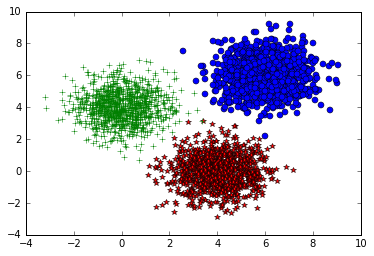

In [28]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

# Initialization

Here suppose we know there are 3 components

In [29]:
%%writefile mr_GMixEmInitialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x) #append the data points 
            yield 1, xj
        index = sample(range(len(cent)), self.options.k) #based on the number of clusters, select those many points randomly
        cent2 = []
        for i in index:
            cent2.append(cent[i])
                
            
        #use the covariance of the selected centers as the starting guess for covariances
        #first, calculate mean of centers
        
        mean = array(cent2[0]) 
        for i in range(1,self.options.k):
            mean = mean + array(cent2[i])
        mean = mean/float(self.options.k) #calculate mean 
        
       
        
        #then accumulate the deviations
        cov = zeros((len(mean),len(mean)),dtype=float)
        for x in cent2:
            xmm = array(x) - mean #calculate x-mu
            for i in range(len(mean)):
                cov[i,i] = cov[i,i] + xmm[i]*xmm[i]
                
        cov = cov/(float(self.options.k))
        covInv = linalg.inv(cov)
        
        cov_1 = [covInv.tolist()]*self.options.k
        
        jDebug = json.dumps([cent2,mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
        
        phi = zeros(self.options.k,dtype=float)
        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)
        
        #form output object
        outputList = [phi.tolist(), cent2, cov_1]
            
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()
        

if __name__ == '__main__':
    MrGMixEmInit.run()

Overwriting mr_GMixEmInitialize.py


In [22]:
! python mr_GMixEmInitialize.py --pathName '/Users/hetal/programming/W261/UCB_MIDS_W261/hw6/' data.txt

using configs in /Users/hetal/.mrjob.conf
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.200756.913065
writing to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.200756.913065/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.200756.913065/step-0-mapper-sorted
> sort /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.200756.913065/step-0-mapper_part-00000
writing to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.200756.913065/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.200756.913065/step-0-reducer_part-00000 -> /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/mr_GMixEmInitialize.hetal.20160221.20

# Iteration

**Mapper** – each mapper needs k vector means and covariance matrices to make probability calculations.  Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update.  Then it emits partial sum as single output from combiner.  
    Emit (dummy_key, partial_sum_for_all_k's)

**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer.  In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [37]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

#using equation 2 we will calculate the p(w_k) for each sample using gaussian distribution
# @x = input data
# @mu = mean 
# @inv_cov = inverted covariance matrix 
# @p = class probability for class k
def gauss(x, mu, inv_cov): 
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(inv_cov,xtemp)))
    detP = 1/linalg.det(inv_cov)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt' # read values of phi, mu and sigma
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        temp = inputList[0]        
        self.phi = array(temp)           #prior class probabilities
        temp = inputList[1]
        self.means = array(temp)         #current means list
        temp = inputList[2]
        self.cov_1 = array(temp)         #inverse covariance matrices for w, calc.
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        #accumulate partial sums for each mapper
        xList = json.loads(val)
        x = array(xList) #convetr data to array
        wtVect = zeros_like(self.phi) #this variable is used to hold the class probabilities from equation 1
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.means[i],self.cov_1[i]) 
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        #accumulate weights for phi est
        self.new_phi = self.new_phi + wtVect #as we have computed partial phi added to the variable that will be used later
        for i in range(self.options.k):
            #accumulate weighted x's for mean calc
            self.new_means[i] = self.new_means[i] + wtVect[i]*x #based on equation 3 calculate parital counts for mean
            #accumulate weighted squares for cov estimate
            xmm = x - self.means[i]
            covInc = zeros_like(self.new_cov[i])
            
            for l in range(len(xmm)): #based on equation 4 calculate parital counts for covariance
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_cov[i] = self.new_cov[i] + wtVect[i]*covInc     
        #dummy yield - real output passes to mapper_final in self

        
    def mapper_final(self):
        
        out = [self.count, (self.new_phi).tolist(), (self.new_means).tolist(), (self.new_cov).tolist()]
        jOut = json.dumps(out)        
        
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #accumulate partial sums
        first = True        
        #accumulate partial sums
        #xs us a list of paritial stats, including count, phi, mean, and covariance. 
        #Each stats is k-length array, storing info for k components
        for val in xs:
            if first:
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPhi = array(temp[1])
                totMeans = array(temp[2])
                totCov = array(temp[3])                
                first = False
            else:
                temp = json.loads(val)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPhi = totPhi + array(temp[1])
                totMeans = totMeans + array(temp[2])
                totCov = totCov + array(temp[3])
        #finish calculation of new probability parameters. array divided by array
        newPhi = totPhi/totCount
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPhi[i]
            tempCov = totCov[i,:,:]/totPhi[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1[i,:,:] = linalg.inv(tempCov)
        
        outputList = [newPhi.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


# Driver

Iteration0
[[6.279894978154345, 5.257330715613044], [7.873512373367164, 5.809850345829621], [-0.32672990361761306, 3.6340722827303633]]


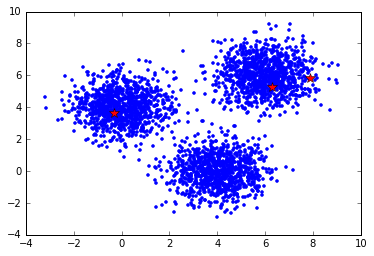

Iteration1
[[4.445781246085512, 5.5325505986921435], [5.5308323388194, 6.248990378465259], [2.271548834114932, 1.7036651917107395]]


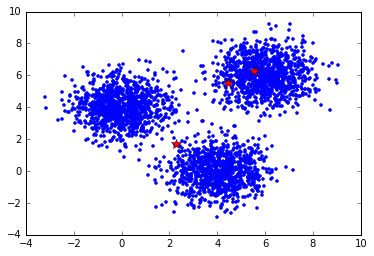

Iteration2
[[4.537792314703438, 5.486719910714286], [5.706023567920584, 6.2363612205368995], [2.1774515669335894, 1.7096118702738916]]


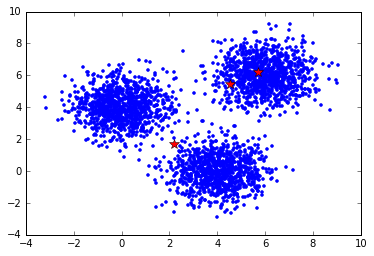

Iteration3
[[4.424203872281263, 5.415985903924055], [5.942852819547253, 6.240681137796021], [2.1388415477672464, 1.7644316652492906]]


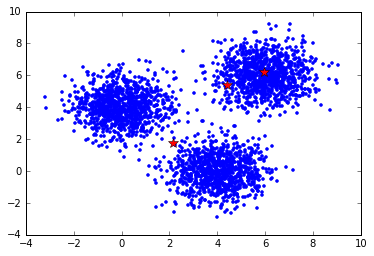

Iteration4
[[4.117457189056481, 5.334444756418295], [6.01188263177983, 6.201270825007131], [2.135887488047603, 1.7790986828217281]]


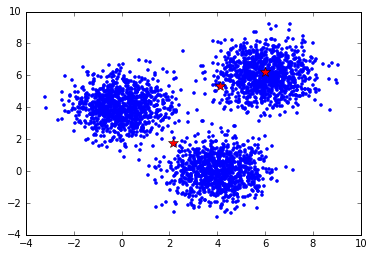

Iteration5
[[3.6963889908597602, 5.253806317186007], [6.029766121979363, 6.1597598780589085], [2.1494079536481228, 1.7721540876621749]]


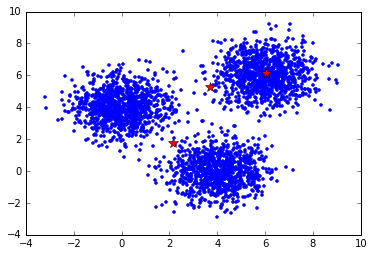

Iteration6
[[3.218012068762842, 5.167324286696383], [6.034851332240156, 6.128275265514262], [2.1718705210089353, 1.7543246487659725]]


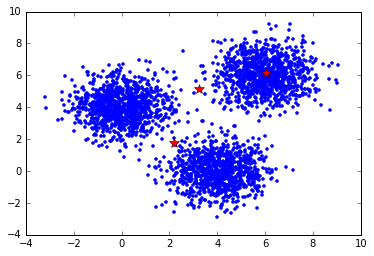

Iteration7
[[2.7364801187150682, 5.0768621140634895], [6.036933968746251, 6.105338122137507], [2.1981131380963888, 1.731856767590142]]


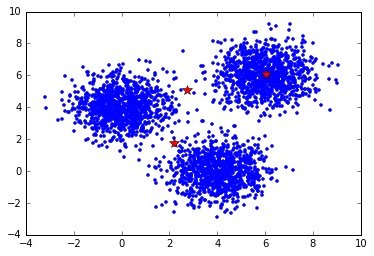

Iteration8
[[2.288186711854663, 4.987985033304024], [6.039181821141742, 6.088517217990741], [2.225617121939616, 1.7073329032590452]]


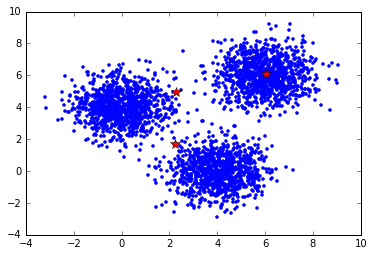

Iteration9
[[1.8780773376984592, 4.901968662389243], [6.042066723908548, 6.075811217532532], [2.254666579183074, 1.6802643628458853]]


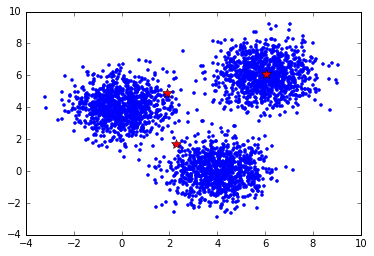

Iteration10
[[1.4907544832624575, 4.815878932528105], [6.044902605072473, 6.065638047040124], [2.287437896372398, 1.648399491660456]]


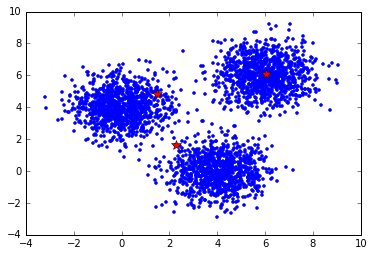

Iteration11
[[1.1070701048736886, 4.725176558215101], [6.046036486153068, 6.056752384916311], [2.3276222253897876, 1.6080223685666788]]


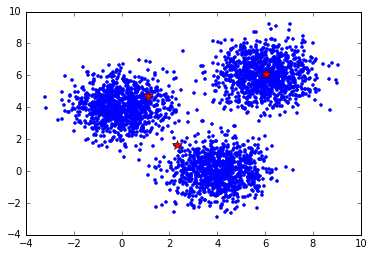

Iteration12
[[0.7216623651828911, 4.626941544739951], [6.041798389311832, 6.048101772486607], [2.3815255823416206, 1.5527803624969216]]


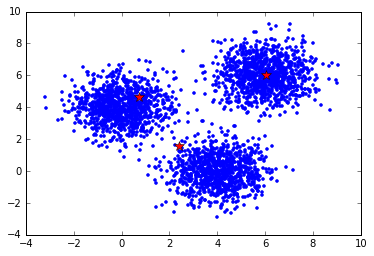

Iteration13
[[0.3627100185141847, 4.524913111209476], [6.027365481154624, 6.039019178013716], [2.4601128136830295, 1.4719134596378094]]


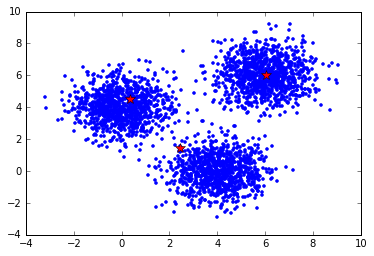

Iteration14
[[0.09231956457836006, 4.432611087981517], [6.004239004543659, 6.030570857774486], [2.578851285506467, 1.3514586520885876]]


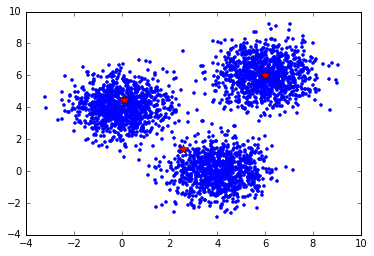

Iteration15
[[-0.04713742828365479, 4.364136890058017], [5.9851746184648835, 6.025821452023862], [2.7448259762050844, 1.1884188859972165]]


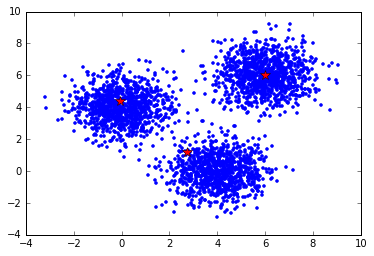

Iteration16
[[-0.1014295206705034, 4.3154292007251405], [5.977787078350186, 6.0246528008409], [2.93446601350768, 1.009250023649313]]


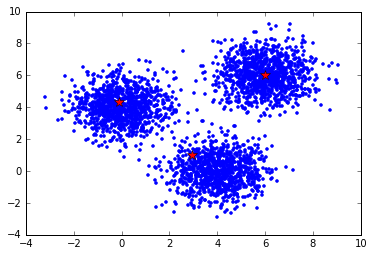

Iteration17
[[-0.1240576733247634, 4.274986395511773], [5.975822183936477, 6.0245360744594025], [3.1285577215664246, 0.8294302390588278]]


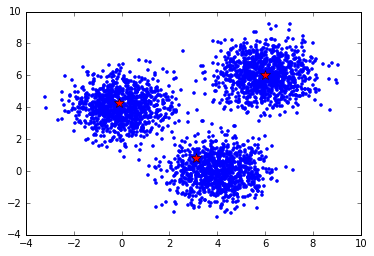

Iteration18
[[-0.13057970018195275, 4.236602911519875], [5.9751684419210775, 6.024591924654377], [3.3300453965125425, 0.6431044707857397]]


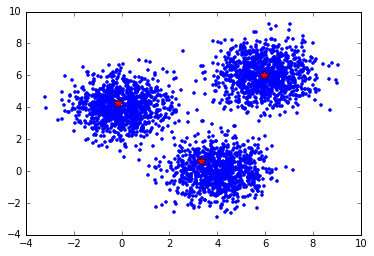

Iteration19
[[-0.1200731417609, 4.193753409339565], [5.974799621977394, 6.024614756226106], [3.5403982547743045, 0.4471199512713658]]


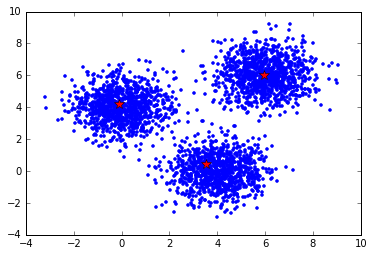

Iteration20
[[-0.08714724423433531, 4.140175841378882], [5.974428092608162, 6.024537952873005], [3.7436972674247455, 0.2549203021881647]]


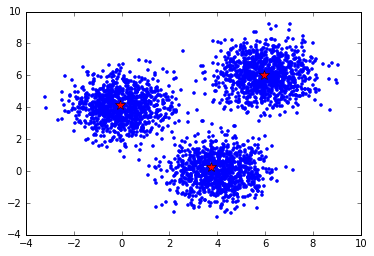

Iteration21
[[-0.04126608593291978, 4.084844601957122], [5.9739069578224795, 6.02420873389813], [3.9057503104582434, 0.0978350638684079]]


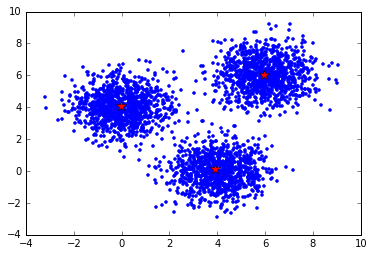

Iteration22
[[-0.005947122289674059, 4.047577978194928], [5.973228691656404, 6.023441042161633], [3.988688257852517, 0.014376352072392346]]


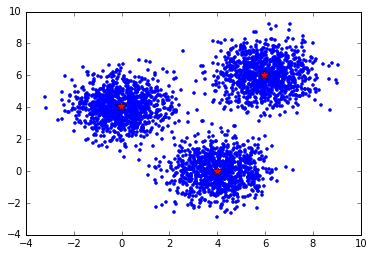

Iteration23
[[0.00877406488335114, 4.033066721553878], [5.972724932091526, 6.022495173759782], [4.010839672370439, -0.009383390366625378]]


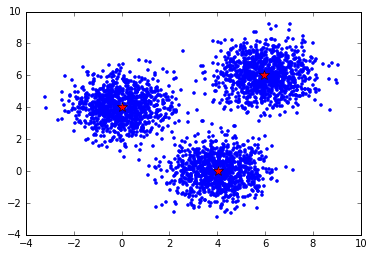

Iteration24
[[0.012984437721782757, 4.029274430481171], [5.97255981231888, 6.022004183715125], [4.015062556290746, -0.014522966313396285]]


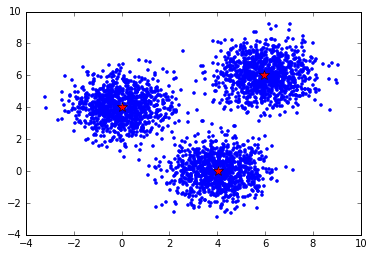

In [38]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath,'--pathName','/Users/hetal/programming/W261/UCB_MIDS_W261/hw6/'])
with mrJob.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()

delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldMeans = oldParam[1]
    mrJob2 = MrGMixEm(args=[filePath,'--file',emPath,'--pathName','/Users/hetal/programming/W261/UCB_MIDS_W261/hw6/'])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newMeans = newParam[1]

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    print oldMeans
    plot_iteration(oldMeans)
print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newMeans)